In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from scipy.stats import pearsonr

In [2]:
def load_df():
    label_encoder = preprocessing.LabelEncoder()

    df = pd.read_csv('data/qsar-biodeg.csv')
    df = df.dropna()
    cat = df.select_dtypes(exclude=['number'])
    for col in cat.columns:
        df[col] = label_encoder.fit_transform(df[col])

    df = df.to_numpy()
    target = df[:, -1]- 1 # Target is the last attribute
    data = df[:, :-1]   # Data is everything except the last attribute

    dataset = {'target': target,
               'data': data,
               'info': 'https://www.kaggle.com/datasets/muhammetvarl/qsarbiodegradation?resource=download',
               'date_access': '2023-10-29'}

    return dataset

In [3]:
df = load_df()
display(df)
data = pd.DataFrame(df['data'])
target = df['target']

{'target': array([1., 1., 1., ..., 0., 0., 0.]),
 'data': array([[ 3.919 ,  2.6909,  0.    , ...,  7.253 ,  0.    ,  0.    ],
        [ 4.17  ,  2.1144,  0.    , ...,  7.257 ,  0.    ,  0.    ],
        [ 3.932 ,  3.2512,  0.    , ...,  7.601 ,  0.    ,  0.    ],
        ...,
        [ 4.869 ,  1.767 ,  0.    , ...,  9.537 ,  1.    ,  0.    ],
        [ 5.158 ,  1.6914,  2.    , ..., 11.055 ,  0.    ,  1.    ],
        [ 5.076 ,  2.6588,  2.    , ...,  9.13  ,  0.    ,  2.    ]]),
 'info': 'https://www.kaggle.com/datasets/muhammetvarl/qsarbiodegradation?resource=download',
 'date_access': '2023-10-29'}

In [4]:
random_state = 42
modelos = {
    'Decision Tree': tree.DecisionTreeClassifier(random_state=random_state),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=1000000, random_state=random_state),
    'Random Forest': RandomForestClassifier(random_state=random_state),
    'SVM': SVC(random_state=random_state),
    'Logistic Regression': LogisticRegression(max_iter=1000000, random_state=random_state),
    'XGBoost': xgb.XGBClassifier(random_state=random_state)
}

In [5]:
def calculate_pearson_correlations(data, target):
    pearson_correlations = {}
    for column in data.columns:
        feature_values = data[column].values
        target_values = target
        pearson_corr, _ = pearsonr(feature_values, target_values)
        pearson_correlations[column] = pearson_corr
    return pearson_correlations

def select_top_and_bottom_features(correlations, percentage=0.3):
    sorted_correlations = sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True)
    n_features = int(len(sorted_correlations) * percentage)
    top_features = sorted_correlations[:n_features]
    bottom_features = sorted_correlations[-n_features:]
    return top_features, bottom_features

def remove_features(data, features):
    data_df = pd.DataFrame(data)
    columns_to_remove = [feature[0] for feature in features]
    data_df.drop(columns=columns_to_remove, inplace=True)
    updated_data = data_df.to_numpy()
    return updated_data

def evaluate_models(data, target, n_iterations=1, test_size=0.2, random_state=42):
    acuracias = {nome_modelo: [] for nome_modelo in modelos}
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size, random_state=random_state)
    for _ in range(n_iterations):
        for nome_modelo, modelo in modelos.items():
            modelo.fit(X_train, y_train)
            val_predictions = modelo.predict(X_test)
            acuracia = accuracy_score(y_test, val_predictions)
            acuracias[nome_modelo].append(acuracia)
    medias_acuracias = {nome_modelo: np.mean(acuracias[nome_modelo]) for nome_modelo in acuracias}
    return medias_acuracias

In [6]:
def plot_results(original, top_removed, bottom_removed):
    sns.set(style="whitegrid")
    model_names = list(original.keys())
    
    original_accuracies = list(original.values())
    top_removed_accuracies = list(top_removed.values())
    bottom_removed_accuracies = list(bottom_removed.values())
    
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.figure(figsize=(14, 8))
    
    plt.bar(x - width, original_accuracies, width, label='Original')
    plt.bar(x, top_removed_accuracies, width, label='Without Top 15% Features')
    plt.bar(x + width, bottom_removed_accuracies, width, label='Without Bottom 15% Features')
    
    plt.xlabel('Model')
    plt.ylabel('Average Accuracy')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.ylim(0, 1)
    plt.legend()
    
    for i in range(len(model_names)):
        plt.text(i - width, original_accuracies[i] + 0.01, f'{original_accuracies[i]:.2f}', ha='center', va='bottom')
        plt.text(i, top_removed_accuracies[i] + 0.01, f'{top_removed_accuracies[i]:.2f}', ha='center', va='bottom')
        plt.text(i + width, bottom_removed_accuracies[i] + 0.01, f'{bottom_removed_accuracies[i]:.2f}', ha='center', va='bottom')
    
    plt.show()

Original Data Shape: (1055, 41)
Data Shape without Top 15% Features: (1055, 29)
Data Shape without Bottom 15% Features: (1055, 29)
Original Data Evaluation:
Data without Top 15% Features Evaluation:
Data without Bottom 15% Features Evaluation:


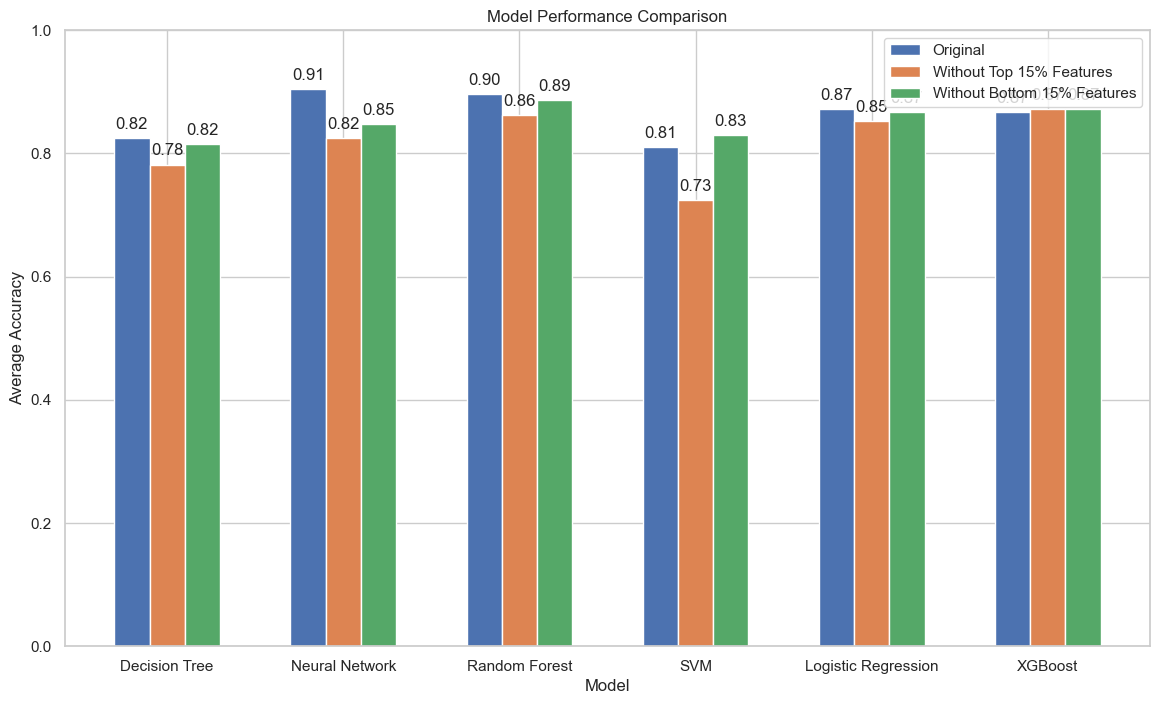

In [7]:
# Carrega o DataFrame
dataset = load_df()
data = dataset['data']
target = dataset['target']

# Calcula as correlações de Pearson
pearson_corr = calculate_pearson_correlations(pd.DataFrame(data), target)

# Seleciona 15% dos melhores e piores atributos
top_features, bottom_features = select_top_and_bottom_features(pearson_corr)

# Remove os atributos correlacionados do DataFrame
data_no_top_features = remove_features(data, top_features)
data_no_bottom_features = remove_features(data, bottom_features)

print("Original Data Shape:", data.shape)
print("Data Shape without Top 15% Features:", data_no_top_features.shape)
print("Data Shape without Bottom 15% Features:", data_no_bottom_features.shape)

# Avalia os modelos com os dados originais
print("Original Data Evaluation:")
original_evaluation = evaluate_models(data, target)

# Avalia os modelos sem os melhores 15%
print("Data without Top 15% Features Evaluation:")
top_removed_evaluation = evaluate_models(data_no_top_features, target)

# Avalia os modelos sem os piores 15%
print("Data without Bottom 15% Features Evaluation:")
bottom_removed_evaluation = evaluate_models(data_no_bottom_features, target)

# Plota os resultados
plot_results(original_evaluation, top_removed_evaluation, bottom_removed_evaluation)